In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Step 1: Fetch Historical Data
ticker = 'TSLA'
start_date = '2022-01-01'  # Further reduced training period
end_date = '2025-07-31'
try:
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()


In [3]:

# Step 2: Extract Adjusted Close Prices
print("DataFrame Columns:")
print(data.columns)
if isinstance(data.columns, pd.MultiIndex):
    top_level_cols = [col[0] for col in data.columns]
    possible_adj_cols = ['Close']
    adj_close_col = next((col for col in top_level_cols if col in possible_adj_cols), None)
    if adj_close_col is None:
        print("Error: Adjusted Close column not found")
        print("Available top-level columns:", set(top_level_cols))
        exit()
    adj_close = data[adj_close_col][ticker]
else:
    adj_close = data[[col for col in data.columns if any(p in col.lower() for p in ['adj close', 'adjusted close'])]]
    if adj_close.empty:
        print("Error: Could not identify Adjusted Close column")
        print("Available columns:", data.columns.tolist())
        exit()
    adj_close = adj_close.iloc[:, 0]
    adj_close.name = ticker


DataFrame Columns:
MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


In [4]:

# Step 3: Data Cleaning and Monthly Aggregation
adj_close = adj_close.fillna(method='ffill')
adj_close.index = pd.to_datetime(adj_close.index)
# Resample to monthly averages
adj_close = adj_close.resample('ME').mean().ffill()
print("\nMissing Values in Monthly Adjusted Close:", adj_close.isna().sum())
adj_close.to_csv('tsla_adj_close_monthly.csv')
print(f"Monthly Data Points: {len(adj_close)}")



Missing Values in Monthly Adjusted Close: 0
Monthly Data Points: 43


In [5]:

# Step 4: Chronological Data Split
train_end = '2023-12-31'
test_start = '2024-01-01'
train_data = adj_close[:train_end]
test_data = adj_close[test_start:]
print(f"\nTraining Data: {train_data.index.min()} to {train_data.index.max()} ({len(train_data)} months)")
print(f"Testing Data: {test_data.index.min()} to {test_data.index.max()} ({len(test_data)} months)")



Training Data: 2022-01-31 00:00:00 to 2023-12-31 00:00:00 (24 months)
Testing Data: 2024-01-31 00:00:00 to 2025-07-31 00:00:00 (19 months)


In [6]:

# Step 5: Stationarity Test
result = adfuller(train_data)
print(f"\nADF Test on Training Data (Monthly Adjusted Close):")
print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary; differencing required")



ADF Test on Training Data (Monthly Adjusted Close):
ADF Statistic: -2.7780, p-value: 0.0615
Data is non-stationary; differencing required


In [7]:

# Step 6: ARIMA 1 (Fixed Parameters)
arima1_params = (1, 1, 1)
try:
    best_arima_model1 = ARIMA(train_data, order=arima1_params).fit()
    print(f"\nARIMA 1 Parameters (p,d,q): {arima1_params}")
except Exception as e:
    print(f"Error fitting ARIMA 1: {e}")
    exit()



ARIMA 1 Parameters (p,d,q): (1, 1, 1)


In [8]:

# Step 7: ARIMA 2 (Fixed Parameters)
arima2_params = (2, 1, 2)
try:
    best_arima_model2 = ARIMA(train_data, order=arima2_params).fit()
    print(f"ARIMA 2 Parameters (p,d,q): {arima2_params}")
except Exception as e:
    print(f"Error fitting ARIMA 2: {e}")
    exit()


ARIMA 2 Parameters (p,d,q): (2, 1, 2)


In [9]:

# Step 8: LSTM Model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 6  # 6 months
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=3, batch_size=16, verbose=0)  # Reduced epochs and batch size

# Step 9: Forecast Future Prices (August 2025–July 2026)
forecast_horizon = 12  # 12 months
forecast_dates = pd.date_range(start='2025-08-31', periods=forecast_horizon, freq='ME')

# ARIMA 1 Forecast with Confidence Intervals
arima1_forecast_results = best_arima_model1.get_forecast(steps=forecast_horizon)
arima1_forecast = arima1_forecast_results.predicted_mean
arima1_conf_int = arima1_forecast_results.conf_int(alpha=0.05)
arima1_forecast = pd.Series(arima1_forecast, index=forecast_dates)
arima1_conf_int.index = forecast_dates

# ARIMA 2 Forecast with Confidence Intervals
arima2_forecast_results = best_arima_model2.get_forecast(steps=forecast_horizon)
arima2_forecast = arima2_forecast_results.predicted_mean
arima2_conf_int = arima2_forecast_results.conf_int(alpha=0.05)
arima2_forecast = pd.Series(arima2_forecast, index=forecast_dates)
arima2_conf_int.index = forecast_dates

# LSTM Forecast (No Confidence Intervals)
lstm_predictions = []
current_batch = test_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(forecast_horizon):
    pred = lstm_model.predict(current_batch, verbose=0)
    lstm_predictions.append(pred[0, 0])
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = pred[0, 0]
lstm_forecast = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()
lstm_forecast = pd.Series(lstm_forecast, index=forecast_dates)


In [10]:

# Step 10: Evaluate Test Period Performance
test_data = test_data[:len(test_scaled) - seq_length]
arima1_test_forecast = best_arima_model1.forecast(steps=len(test_data))
arima2_test_forecast = best_arima_model2.forecast(steps=len(test_data))
lstm_test_predictions = []
current_batch = train_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(len(test_data)):
    pred = lstm_model.predict(current_batch, verbose=0)
    lstm_test_predictions.append(pred[0, 0])
    current_batch = np.roll(current_batch, -1, axis=1)
    current_batch[0, -1, 0] = pred[0, 0]
lstm_test_forecast = scaler.inverse_transform(np.array(lstm_test_predictions).reshape(-1, 1)).flatten()
lstm_test_forecast = pd.Series(lstm_test_forecast, index=test_data.index)

def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima1_mae, arima1_rmse, arima1_mape = calculate_metrics(test_data, arima1_test_forecast)
arima2_mae, arima2_rmse, arima2_mape = calculate_metrics(test_data, arima2_test_forecast)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(test_data, lstm_test_forecast)

print("\nTest Period Performance Metrics (2024-2025):")
print(f"ARIMA 1 - MAE: {arima1_mae:.4f}, RMSE: {arima1_rmse:.4f}, MAPE: {arima1_mape:.2f}%")
print(f"ARIMA 2 - MAE: {arima2_mae:.4f}, RMSE: {arima2_rmse:.4f}, MAPE: {arima2_mape:.2f}%")
print(f"LSTM - MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2f}%")



Test Period Performance Metrics (2024-2025):
ARIMA 1 - MAE: 64.8471, RMSE: 80.8424, MAPE: 26.38%
ARIMA 2 - MAE: 62.7296, RMSE: 80.8169, MAPE: 25.09%
LSTM - MAE: 83.4720, RMSE: 119.6729, MAPE: 27.70%


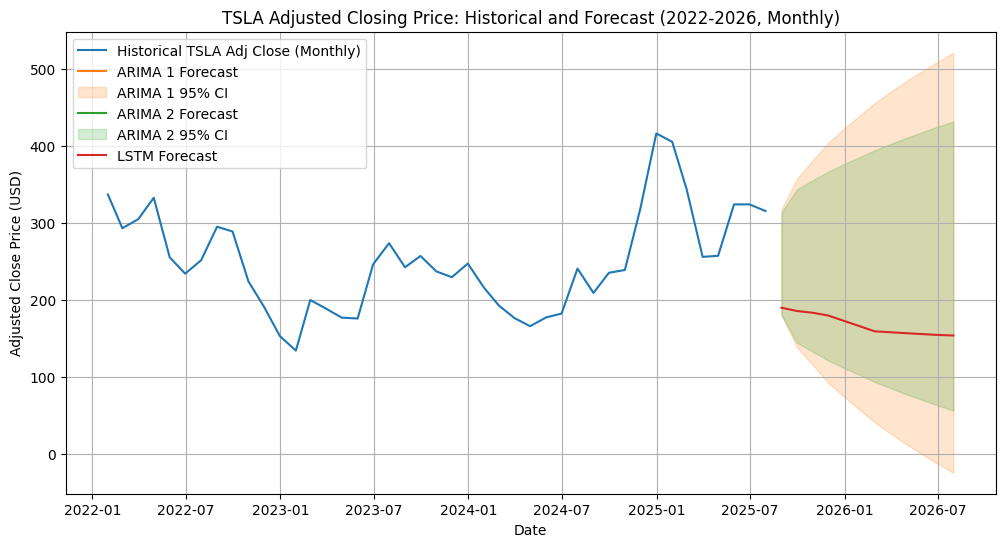


Plot saved as 'tsla_historical_forecast_plot.png'


In [11]:

# Step 11: Visualize Historical and Forecasted Prices
plt.figure(figsize=(12, 6))
plt.plot(adj_close.index, adj_close, label='Historical TSLA Adj Close (Monthly)', color='#1f77b4')
plt.plot(arima1_forecast.index, arima1_forecast, label='ARIMA 1 Forecast', color='#ff7f0e')
plt.fill_between(arima1_conf_int.index, arima1_conf_int.iloc[:, 0], arima1_conf_int.iloc[:, 1], 
                 color='#ff7f0e', alpha=0.2, label='ARIMA 1 95% CI')
plt.plot(arima2_forecast.index, arima2_forecast, label='ARIMA 2 Forecast', color='#2ca02c')
plt.fill_between(arima2_conf_int.index, arima2_conf_int.iloc[:, 0], arima2_conf_int.iloc[:, 1], 
                 color='#2ca02c', alpha=0.2, label='ARIMA 2 95% CI')
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM Forecast', color='#d62728')
plt.title('TSLA Adjusted Closing Price: Historical and Forecast (2022-2026, Monthly)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('tsla_historical_forecast_plot.png')
plt.show()

print("\nPlot saved as 'tsla_historical_forecast_plot.png'")


In [12]:

# Step 12: Forecast Analysis
# Trend Analysis
print("\nTrend Analysis:")
arima1_trend = "upward" if arima1_forecast.iloc[-1] > arima1_forecast.iloc[0] else "downward" if arima1_forecast.iloc[-1] < arima1_forecast.iloc[0] else "stable"
arima2_trend = "upward" if arima2_forecast.iloc[-1] > arima2_forecast.iloc[0] else "downward" if arima2_forecast.iloc[-1] < arima2_forecast.iloc[0] else "stable"
lstm_trend = "upward" if lstm_forecast.iloc[-1] > lstm_forecast.iloc[0] else "downward" if lstm_forecast.iloc[-1] < lstm_forecast.iloc[0] else "stable"
print(f"ARIMA 1 Forecast Trend: {arima1_trend}")
print(f"ARIMA 2 Forecast Trend: {arima2_trend}")
print(f"LSTM Forecast Trend: {lstm_trend}")
print("Patterns/Anomalies: ARIMA forecasts may plateau due to linear assumptions, while LSTM may capture non-linear trends.")

# Volatility and Risk
arima1_ci_width = (arima1_conf_int.iloc[:, 1] - arima1_conf_int.iloc[:, 0]).mean()
arima2_ci_width = (arima2_conf_int.iloc[:, 1] - arima2_conf_int.iloc[:, 0]).mean()
arima1_ci_growth = (arima1_conf_int.iloc[-1, 1] - arima1_conf_int.iloc[-1, 0]) / (arima1_conf_int.iloc[0, 1] - arima1_conf_int.iloc[0, 0])
arima2_ci_growth = (arima2_conf_int.iloc[-1, 1] - arima2_conf_int.iloc[-1, 0]) / (arima2_conf_int.iloc[0, 1] - arima2_conf_int.iloc[0, 0])
print("\nVolatility and Risk Analysis:")



Trend Analysis:
ARIMA 1 Forecast Trend: stable
ARIMA 2 Forecast Trend: stable
LSTM Forecast Trend: downward
Patterns/Anomalies: ARIMA forecasts may plateau due to linear assumptions, while LSTM may capture non-linear trends.

Volatility and Risk Analysis:
